Импорт библиотек и настройки

Для отрисовки воронок (plotly funnel) может потребоваться библиотека chart_studio, т.к. github не показывает по умолчанию интерактивные графики

In [1]:
pip install chart_studio

Note: you may need to restart the kernel to use updated packages.


In [92]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from plotly import graph_objects as go
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import math as mth
import plotly.express as px
import chart_studio.plotly as py
import plotly.io as pio


from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)


pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
pd.set_option('display.max_colwidth', None)  #текст в ячейке отражается полностью
pd.set_option('display.float_format', '{:.2f}'.format) # формат чисел по умолчанию в таблицах с 2 знаками после запятой

# Загрузка и проверка данных

## Загрузим данные и подготовим их к анализу:

In [3]:
#для файлов  на локальной машине
mobile_sourсes = pd.read_csv('mobile_sourсes.csv')
mobile_dataset = pd.read_csv('mobile_dataset.csv')

## Убедимся, что тип данных во всех колонках соответствует значениям. Проверим отсутствие дубликатов, посмотрим на пропуски:

In [4]:
def get_df_name(df):
    """функция возвращает название датафрейма как строку (делает заголовок к описанию датасета)"""
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def data_describe(data):
    """функция с обобщением описания - просмотра данных и числовых характеристик переменных"""
    print(f"\033[1m\033[4m\033[96m{get_df_name(data)}\033[0m") #печатаем название датасета, чтобы не запутаться
    display(data.head(3))
    display(data.describe().T)
    display(data.info())
    print('число дубликатов',data.duplicated().sum())
    print('')
    print('число пропусков, %','\n', round((data.isna().mean()*100),2), sep='')
    print('')

Ребята одногруппники предлагали вариант предварительный анализ делать через ProfileReport из pandas_profiling, я поставила библиотеку, посмотрела, для меня не очень наглядно, поэтому сделала через свою функцию, которая мне уже несколько раз на проектах пригождалась

In [5]:
for i in [mobile_sourсes,mobile_dataset]:
    data_describe(i)

mobile_sourсes


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


,count,unique,top,freq
userId,4293,4293,020292ab-89bc-4156-9acf-68bc2783f894,1
source,4293,3,yandex,1934


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

число дубликатов 0

число пропусков, %
userId   0.00
source   0.00
dtype: float64

mobile_dataset


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,count,unique,top,freq
event.time,74197,74197,2019-10-07 00:00:00.431357,1
event.name,74197,16,tips_show,40055
user.id,74197,4293,cb36854f-570a-41f4-baa8-36680b396370,478


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

число дубликатов 0

число пропусков, %
event.time   0.00
event.name   0.00
user.id      0.00
dtype: float64



переименуем переменные в датасетах для удобства:

In [6]:
mobile_dataset.columns=['event_time','event_name','user_id']
mobile_sourсes.columns=['user_id', 'source']

In [7]:
for i in [mobile_sourсes,mobile_dataset]:
    display(i.head(3))

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Заменим тип в столбце event_time на datetime и добавим столбец дат. Также изменим формат отображения времени события с точностью только до секунды:

In [8]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset['date'] = mobile_dataset['event_time'].map(lambda x: dt.datetime.date(x) )
mobile_dataset['event_time']=mobile_dataset['event_time'].dt.floor('s')
mobile_dataset.head(3)

,event_time,event_name,user_id,date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


Явных дубликатов и пропусков в датасетах нет, посмотрим, есть ли неявные дубликаты

In [9]:
mobile_sourсes.groupby(['source']).count().sort_values(by='user_id', ascending = False)

,user_id
source,
yandex,1934
other,1230
google,1129


У нас есть пользователи, которые перешли из поисковиков yandex и google, а также пользователи, помеченные `other`.

В other находятся пользователи, которые перешли по ссылкам на прочих сайтах.

## Проверим, есть ли дублирующие значения в переменных (show_contacts и contacts_show например), что с ними можно сделать?

In [10]:
mobile_dataset.groupby(['event_name'])['user_id'].count().sort_values(ascending = False)

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: user_id, dtype: int64

Объединим записи contacts_show  и show_contacts, потому что это один тип событий

In [11]:
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
mobile_dataset.groupby(['event_name'])['user_id'].count().sort_values(ascending = False)

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: user_id, dtype: int64

## Данными за какой период мы располагаем? 

In [12]:
date_time = mobile_dataset.pivot_table(index = 'date', values = 'event_time', aggfunc = 'nunique').reset_index()

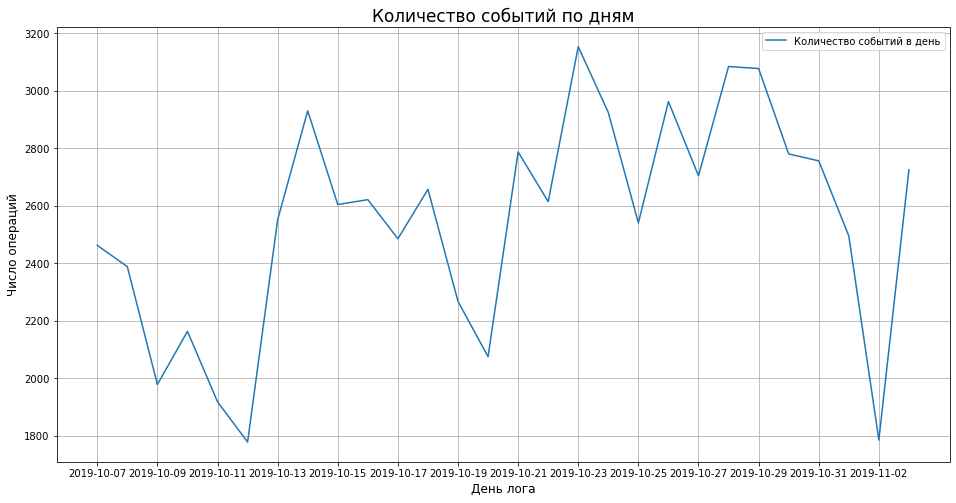

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(date_time['date'], date_time['event_time'], label='Количество событий в день')

plt.legend()
labels = [i for i in list(date_time['date'])[::2]]
plt.xticks(labels) # замена названий меток по оси X
plt.title('Количество событий по дням', fontsize=17)
plt.xlabel('День лога', fontsize=12)
plt.ylabel('Число операций', fontsize=12)
plt.grid(True)
plt.show()

Для анализа в датасете используется интервал времени с 7 октября 2019 по 3 ноября 2019 -  ровно 4 недели, есть дни, в  которые было очень мало событий - 12 октября, 20 октября, 2 ноября - они приходятся на выходные дни, субботу или воскресенье, но тогда странно, что не было провала по числу событий 26 или 27 октября. + 3 ноября приходится на день перед дополнительным выходным
Можно сделать предварительный вывод, что количество событий в начале выходных резко падает, а потом резко возрастает, то есть пользователи сначала "выдыхают" после рабочей недели, а только потом, отдохнув, совершают гораздо больше действий, чем до выходных.

Посмотрим на динамику количества событий по отдельным типам событий, обратим внимание на то, что в некоторых случаях динамики в изменении количества событий не наблюдается, например для событий search_6 и search_7, а вот contact_show и contacts_call имеют "водораздел" 14 октября, до этой даты в среднем количество событий меньше, чем после этой даты. А такие события как map, вообще показывают отрицательную динамику(уменьшение числа событий с ростом даты), но почему - для меня непонятно

Сначала во время выполнения проекта я построила график отдельно для каждого события, но это занимает слишком много места, поэтому графики совместила на один. По ординате шкала выбрана логарифмической, тк так лучше видны различия для разных типов событий

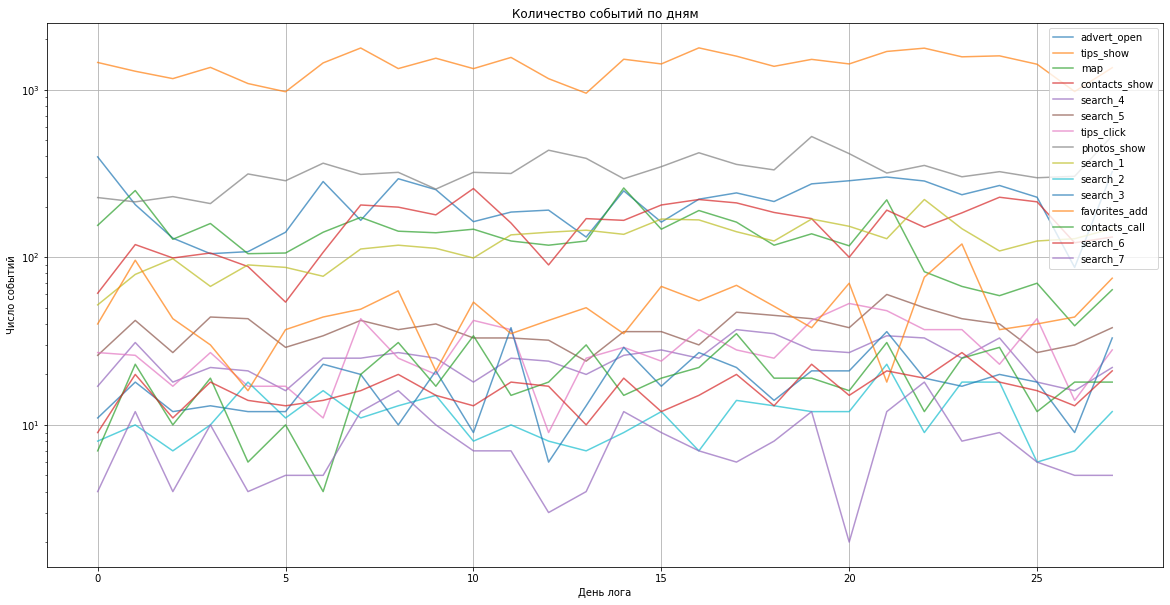

In [14]:
name_dict={}
for name in mobile_dataset['event_name'].unique():
    name_dict[name] = (mobile_dataset[mobile_dataset['event_name']==name].pivot_table(index = 'date',
                                                                      values = 'event_time',
                                                                      aggfunc = 'nunique')
                                                                      .rename(columns={'event_time':name})
                                                                      .reset_index() )[name]
events_plot = pd.DataFrame(name_dict)
events_plot.plot(alpha = 0.7,figsize=(20,10))
plt.legend()
plt.title(f"Количество событий по дням")
plt.xlabel('День лога')
plt.yscale('log')
plt.ylabel('Число событий')
plt.grid(True)
plt.show()                                                                 

tips_show резко отличается по количеству событий, поэтому построим еще раз график, но без этого события (здесь шкала не логарифмическая):

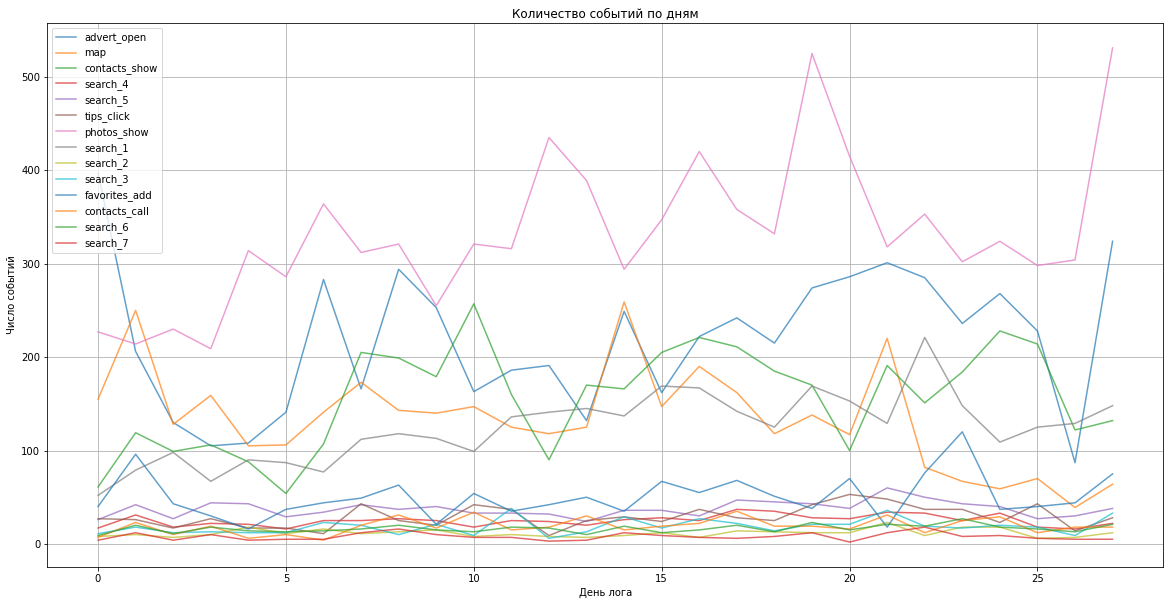

In [15]:
events_plot.drop(columns='tips_show').plot(alpha = 0.7,figsize=(20,10))
plt.legend()
plt.title(f"Количество событий по дням")
plt.xlabel('День лога')
plt.ylabel('Число событий')
plt.grid(True)
plt.show()                                                                 

Как видно из графика выше, мы не можем установить тренд для каждого типа событий, количество событий по каждому подвиду колеблется вокруг некоторого среднего значения, не убывает в целом и не растет.

# Исследовательский анализ данных (EDA)

## Узнаем, как пользователи доходят до целевого события (просмотр контактов). Какие сценарии поведения пользователей возможны и сколько их (сценариев)?  Построим воронки возможных сценариев поведения.  Какие события можно не включать в сценарий поведения пользователя?

Сначала посмотрим на распределение числа совершенных событий 

In [16]:
event_count = (mobile_dataset.pivot_table(index = 'event_name',
                                         values = 'user_id',
                                         aggfunc = 'count').reset_index()
                                         .rename(columns={'user_id': 'count'})
                                         .sort_values(by='count',ascending=False))
event_count

,event_name,count
14,tips_show,40055
5,photos_show,10012
0,advert_open,6164
2,contacts_show,4529
4,map,3881
6,search_1,3506
3,favorites_add,1417
10,search_5,1049
13,tips_click,814
9,search_4,701


Судя по событиям, возможно большое количество воронок, в которые можно включать, а можно и не включать показ советов, поиски на разных страницах приложения, добавление объявления в избранное - эти события точно не являются обязательными. Поэтому я предложу две возможные воронки:

1

tips_show → tips_click → advert_open → contacts_show → contacts_call

2

search_1 → advert_open → photos_show → map → contacts_show → contacts_call

Еще я обратила внимание на события, в которых 2-ое невозможно без первого:


tips_show →  tips_click

contacts_show → contacts_call

На созвоне говорилось о поиске кратчайшего возможного пути пользователя до целевого действия, поэтому мой вариант кратчайшей возможной воронки:

photos_show → advert_open →  contacts_show

(в качестве search_1 может быть любое событие, главное, что оно производится с главной страницы приложения, и приводит к открытию объявления)



1 воронка tips_show → advert_open → contacts_show → contacts_call

In [17]:
list_of_not_events_1 = ['search_1','search_3','search_4','search_5', 'tips_click',
                      'search_6','search_2','search_7','favorites_add','map','photos_show']
event_count_1 = (event_count.query("event_name not in @list_of_not_events_1")
                 .reset_index(drop=True).sort_values(by='count',ascending=False))
event_count_1                             

,event_name,count
0,tips_show,40055
1,advert_open,6164
2,contacts_show,4529
3,contacts_call,541


In [94]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = event_count_1['event_name'],
    x = event_count_1['count'],
    textinfo = "value+percent initial+percent previous"))
iplot(fig) 

2 воронка photos_show  → advert_open → map → contacts_show → contacts_call

In [19]:
list_of_not_events_2 = ['search_3','search_4','search_5', 'tips_click','tips_show', 'search_1',
                      'search_6','search_2','search_7','favorites_add']
event_count_2 = (event_count.query("event_name not in @list_of_not_events_2")
                 .reset_index(drop=True).sort_values(by='count',ascending=False))
event_count_2                             

,event_name,count
0,photos_show,10012
1,advert_open,6164
2,contacts_show,4529
3,map,3881
4,contacts_call,541


In [20]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = event_count_2['event_name'],
    x = event_count_2['count'],
    textinfo = "value+percent initial+percent previous"))

Кратчайшая воронка photos_show → advert_open → contacts_show

In [21]:
list_of_not_events_3 = ['search_3','search_4','search_5', 'tips_click','tips_show', 'search_1', 'map', 'contacts_call',
                      'search_6','search_2','search_7','favorites_add']
event_count_3 = (event_count.query("event_name not in @list_of_not_events_3")
                 .reset_index(drop=True).sort_values(by='count',ascending=False))
event_count_3    

,event_name,count
0,photos_show,10012
1,advert_open,6164
2,contacts_show,4529


In [22]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = event_count_3['event_name'],
    x = event_count_3['count'],
    textinfo = "value+percent initial+percent previous"))

На построенных воронках нет резкого перепадов ("шейки") в количестве пользователей, только если смотреть самый первый этап - показ фото, или показ рекомендованных объявлений, вот после них всегда более резкое уменьшение числа событий. А значит, следует более тщательно прорабатывать алгоритмы, отвечающие за рекомендации (возможно в этом и поможет сегментация пользователей)

## Сколько пользователей доходит до целевого события, а сколько — «застревает» на предыдущих шагах? На каких именно?  Какое событие самое популярное, и чем это можно объяснить?

In [23]:
user_unique =( mobile_dataset
              .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
              .rename(columns={'user_id': 'count'})
              .sort_values(by='count',ascending=False)
              .reset_index()
             )
user_unique['part_from_all, %'] = round(user_unique['count'] / len(mobile_sourсes) *100 , 2)
# уберем события, которые точно могут не входить в обязательный сценарий поведения пользователя
list_of_not = ['search_7','search_3','search_2', 'tips_click','search_6', 'favorites_add',
                      'search_4','search_5','search_1']
user_unique = (user_unique.query("event_name not in @list_of_not").reset_index(drop=True))
user_unique

,event_name,count,"part_from_all, %"
0,tips_show,2801,65.25
1,map,1456,33.92
2,photos_show,1095,25.51
3,contacts_show,981,22.85
4,advert_open,751,17.49
5,contacts_call,213,4.96


981 пользователь из 4293 (22.85%) совершает целевое событие - посмотреть контакты.  

На первом месте стоит показ рекомендаций, его увидели 2801 уникальных пользователей (более 65%  от общего количества), но на втором месте стоит событие "открыть карту", что означает, что местоположение продавца имеет преимущественное значение среди всех событий, связанных с объявлением (картой пользуются чаще, чем просмотром фото ). Причем, я не могу утверждать, что в данном перечне событий они расположены именно таким образом, как будут проходить в воронке (мы можем сначала открыть фото,а потом карту или сначала открыть контакты, а потом карту). Тем не менее, для данного перечня все равно выстроим воронку, чтобы визуализировать таблицу:

In [24]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = user_unique['event_name'],
    x = user_unique['part_from_all, %'],
    textinfo = "value+percent initial+percent previous"))

В этой воронке лично меня смущает, что количество уникальных пользователей, которые посмотрели контакты, больше, чем число пользователей, открывших объявления. Возможно для просмотра контактов необязательно открывать само объявление - например, в поисковой выдаче есть краткое саммари и возможность посмотреть номер телефона.

## Сколько в среднем приходится событий на одного пользователя?

In [25]:
user_event = mobile_dataset.pivot_table(index = 'user_id', values = 'event_name', aggfunc = 'count').reset_index()
round(user_event['event_name'].median(),2)

9.0

In [26]:
user_event.head(3)

,user_id,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10


In [27]:
user_event.describe()

,event_name
count,4293.00
mean,17.28
std,29.13
min,1.00
25%,5.00
50%,9.00
75%,17.00
max,478.00


Мы видим, что минимальное количество событий на пользователя 1, то есть каждый из пользователей совершал хотя бы одно действие, но среднее значение числа событий 17, при этом медиана 9 событий. И есть пользователь, который совершил 478 событий!

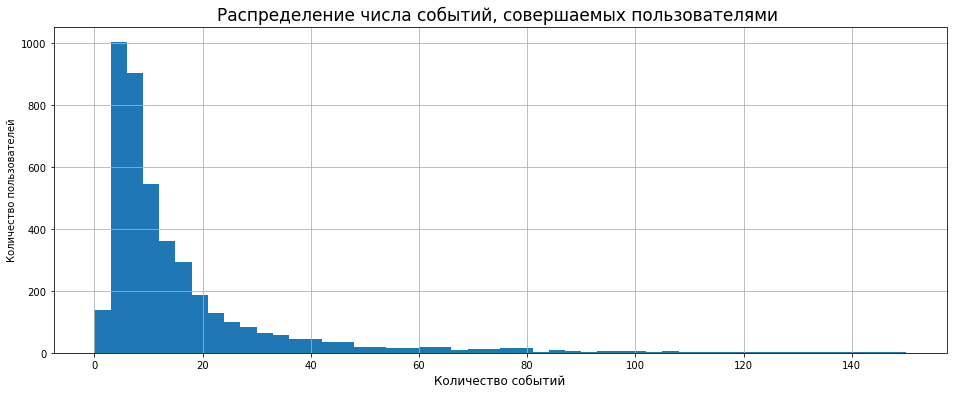

In [28]:
plt.figure(figsize=(16,6))
user_event['event_name'].hist(bins = 50, range=(0,150))
plt.title('Распределение числа событий, совершаемых пользователями ', fontsize=17)
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Количество пользователей')
plt.show()

##  Вычислим основные метрики для пользователей:
retention rate

время, проведенное в приложении

частота действий

Сколько пользователей совершает целевое действие - просмотр контактов (конверсия), по отношению к количеству пользователей, совершивших предыдущие действия

In [29]:
user_unique.loc[3, 'part_from_all, %'] 

22.85

**конверсия:**
22.85% пользователей совершают просмотр контактов, по отношению к общему количеству пользователей

In [30]:
full_data = mobile_dataset.merge(mobile_sourсes[['user_id','source']], on = 'user_id')
full_data.head(3)

,event_time,event_name,user_id,date,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other


Выделение сессий для пользователей выполним по рекомендациям http://datalytics.ru/all/delaem-sessii-iz-loga-sobytiy-s-pomoschyu-pandas/

In [31]:
event_dataset = ( full_data.sort_values(['user_id', 'event_time'], ascending=[True, True])
                 .reset_index().rename(columns={'index': 'id'}) )
event_dataset.head(3)

,id,event_time,event_name,user_id,date,source
0,2171,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
1,2172,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
2,2173,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other


In [32]:
event_dataset['diff'] = event_dataset.groupby('user_id')['event_time'].diff(1)
event_dataset.head(3)

,id,event_time,event_name,user_id,date,source,diff
0,2171,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,NaT
1,2172,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:00:46
2,2173,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:00:34


In [33]:
# сформируем отдельный датасет, в который войдут только события, которые будут считаться первыми событиями сессий
# Это события, которые произошли спустя более чем 30 минут после предыдущего, либо события, которые были первыми 
# для пользователя (NaT в колонке ’diff’).

sessions_start_df = event_dataset[(event_dataset['diff'].isnull()) | (event_dataset['diff'] > '1800 seconds')] 
# 'session_id' показывает id первого события сессии
sessions_start_df['session_id'] = sessions_start_df['id'] 
event_dataset['diff'] = event_dataset['diff'].astype('timedelta64[s]')
sessions_start_df['diff'] = sessions_start_df['diff'].astype('timedelta64[s]') #разница в секундах

In [34]:
#соединим 2 датасета
event_dataset = event_dataset.sort_values('id')
sessions_start_df = sessions_start_df.sort_values('id')
event_dataset = pd.merge_asof(event_dataset,sessions_start_df[['id','user_id','session_id']],on='id',by='user_id')

In [35]:
event_dataset['is_first_event_in_session'] = event_dataset['id'] == event_dataset['session_id']

In [36]:
event_dataset['time_on_page'] = event_dataset.groupby(['session_id'])['event_time'].diff(1)

In [37]:
event_dataset['time_on_page'] = event_dataset.groupby(['session_id'])['time_on_page'].shift(-1)
event_dataset['time_on_page'] = event_dataset['time_on_page'] / np.timedelta64(1, 's')
event_dataset.head(3)

,id,event_time,event_name,user_id,date,source,diff,session_id,is_first_event_in_session,time_on_page
0,0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,NaN,0,True,1.00
1,1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,1.00,0,False,6.00
2,2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,6.00,0,False,80.00


In [38]:
display(event_dataset['session_id'].nunique() ) # Количество сессий
display(round(event_dataset['time_on_page'].mean(),2) ) # Среднее время просмотра страниц

10368

125.51

Среднее время просмотра страницы составляет 125 секунд, что чуть больше, чем 2 минуты

Сколько времени проводят пользователи в приложении? Посчитаем сумму времени на страницах приложения по каждому пользователю

In [39]:
time_in_ap = (event_dataset.groupby('user_id').agg({'time_on_page': 'sum'})
              .rename(columns={'time_on_page': 'sec'}).sort_values(by='sec',ascending=False).reset_index())
time_in_ap['min'] = round( time_in_ap['sec'] / 60 , 2)
time_in_ap['hour'] = round( time_in_ap['min'] / 60 , 2)
time_in_ap.head(3)

,user_id,sec,min,hour
0,cb36854f-570a-41f4-baa8-36680b396370,101086.00,1684.77,28.08
1,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,68848.00,1147.47,19.12
2,21230dd9-2f7f-4b77-a436-43d4d10388e0,62731.00,1045.52,17.43


In [40]:
round(time_in_ap['min'].mean() ,2)

31.1

In [41]:
time_in_ap['min'].describe()

count   4293.00
mean      31.10
std       62.76
min        0.00
25%        6.07
50%       15.10
75%       33.30
max     1684.77
Name: min, dtype: float64

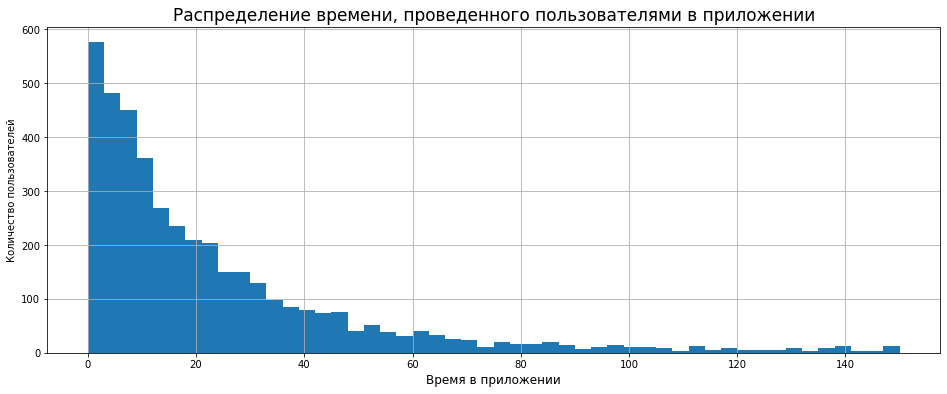

In [42]:
plt.figure(figsize=(16,6))
time_in_ap['min'].hist(bins = 50, range=(0,150)) #хвост распределения обрезан от 150 до 1684 минут
plt.title('Распределение времени, проведенного пользователями в приложении', fontsize=17)
plt.xlabel('Время в приложении', fontsize=12)
plt.ylabel('Количество пользователей')
plt.show()

У нас обнаружились пользователи, которые проводят в приложении часы) На фоне этих у нас обнаружилось 87 пользователей, которые провели в приложении 0 секунд.

In [43]:
len(time_in_ap[time_in_ap['sec']==0])

87

**Частота действий:** Сгруппируем датафрейм по датам и пользователям, посчитав, сколько событий совершает пользователь ежедневно (по точному времени события), потом посчитаем через describe описательные характеристики, и возьмем среднее значение. А уже в среднем возьмем максимальное и минимальное значения:

In [44]:
frequency = (event_dataset.pivot_table(index = 'date', columns='user_id', values = 'event_time', aggfunc = 'count')
             .reset_index().fillna(0))
frequency = frequency.describe().reset_index(drop=True)

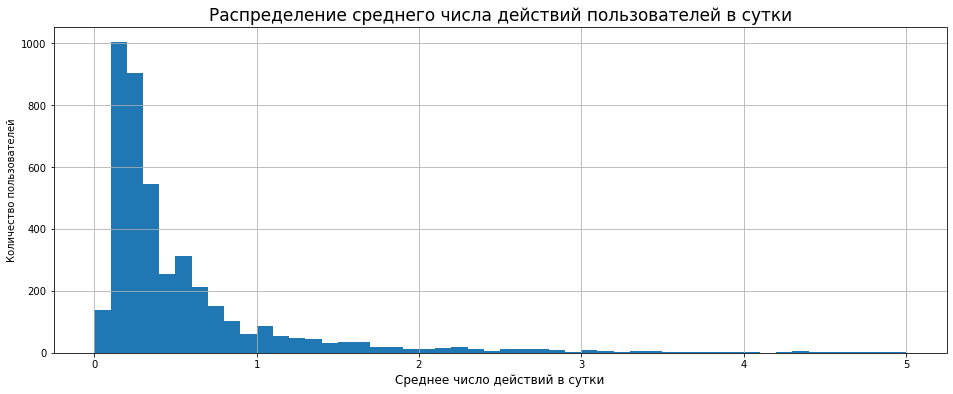

In [45]:
plt.figure(figsize=(16,6))
frequency.iloc[1].hist(bins = 50, range=(0,5))
plt.title('Распределение среднего числа действий пользователей в сутки', fontsize=17)
plt.xlabel('Среднее число действий в сутки', fontsize=12)
plt.ylabel('Количество пользователей')
plt.show()

Основная масса пользователей совершает в сутки от 0 до 2 действий, судя по гистограмме

In [46]:
round(frequency.iloc[1].max(),2)

17.07

In [47]:
round(frequency.iloc[1].min(),2)

0.04

А всего в сутки наши пользователи совершают от 0 до 17 действий.

Для вычисления retention для наших пользователей сделаем таблицу, сгруппированную по id пользователя и содержащую дату первого и последнего использования пользователями нашего приложения:

In [48]:
ret_1 = event_dataset.groupby('user_id').agg({'event_time': 'first'}).rename(columns={'event_time': 'first'}).reset_index()
ret_2 = event_dataset.groupby('user_id').agg({'event_time': 'last'}).rename(columns={'event_time': 'last'}).reset_index()
retention_user = ret_1.merge(ret_2, on = 'user_id')
retention_user = retention_user.merge(event_dataset[['user_id','source']], on = 'user_id' ).drop_duplicates()
retention_user.sort_values(by='first').head(3)

,user_id,first,last,source
497,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,2019-10-07 00:18:42,other
59694,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,2019-10-30 23:39:23,yandex
39113,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,2019-10-07 00:02:07,2019-10-29 23:43:51,yandex


Построим график динамики привлечения по каждому из источников:

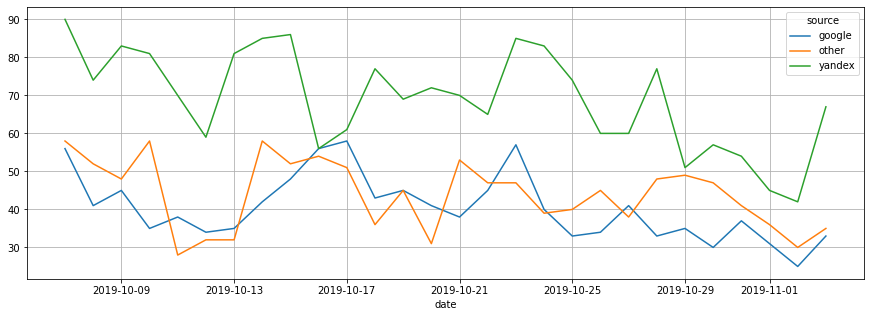

In [49]:
retention_user['date'] = retention_user['first'].map(lambda x: dt.datetime.date(x) )
retention_user.pivot_table(
    index='date',  # даты первых посещений
    columns='source',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

In [50]:
profiles = retention_user #профили пользователей
sessions = (event_dataset.groupby(['session_id'])[['user_id', 'event_time']]
            .agg({'user_id':'first','event_time':'first'})
            .rename(columns={'event_time':'session_start'})
            .reset_index()
           )
sessions.head(3)

,session_id,user_id,session_start
0,0,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00
1,28,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02
2,53,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-08 20:06:41


Вычисление retention оформим через функцию, тк после сегментирования нам потребуется несколько раз оценивать retention (по материалам уроков Яндекс Практикум)

In [51]:
def get_retention(profiles, sessions, observation_date, horizon_days, ignore_horizon=False):
    """Функция для расчета retention"""
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('date <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['date'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('date')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='date', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Возьмем в качестве горизонта 14 дней, а момент анализа 3 ноября. Тогда в наши когорты должны попасть пользователи, зарегистрированные впервые до 21 октября (тк в датасет изначально попали пользователи, зарегистрированные в течение 4 недель). Если будем в дальнейшем выбирать более ранний момент анализа, то тогда и горизонт придется брать меньший.

In [52]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 3).date()
horizon_days = 14

#get_retention(profiles, sessions, observation_date, horizon_days, ignore_horizon=False)
retention_raw, retention = get_retention(profiles, sessions, observation_date, horizon_days)

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
date,,,,,,,,,,,,,,,
2019-10-07,204,1.00,0.12,0.09,0.11,0.05,0.03,0.06,0.08,0.05,0.05,0.05,0.03,0.02,0.06
2019-10-08,167,1.00,0.16,0.13,0.05,0.04,0.07,0.05,0.07,0.05,0.04,0.06,0.02,0.03,0.03
2019-10-09,176,1.00,0.07,0.06,0.06,0.07,0.07,0.06,0.07,0.06,0.03,0.02,0.03,0.03,0.06
2019-10-10,174,1.00,0.09,0.10,0.08,0.09,0.08,0.07,0.05,0.08,0.03,0.03,0.05,0.05,0.04
2019-10-11,136,1.00,0.09,0.12,0.10,0.09,0.07,0.07,0.04,0.01,0.04,0.04,0.04,0.05,0.03
2019-10-12,125,1.00,0.12,0.16,0.06,0.06,0.09,0.08,0.09,0.08,0.06,0.06,0.04,0.07,0.05
2019-10-13,148,1.00,0.13,0.07,0.05,0.07,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.05,0.05
2019-10-14,185,1.00,0.11,0.10,0.10,0.08,0.07,0.05,0.04,0.08,0.04,0.04,0.05,0.02,0.06
2019-10-15,186,1.00,0.13,0.09,0.08,0.05,0.05,0.08,0.08,0.06,0.02,0.04,0.04,0.03,0.04


Визуализируем удержание через тепловую карту, убрав столбец с размером когорт и с нулевым лайфтаймом, через изменение шкалы добьемся контрастности изображения

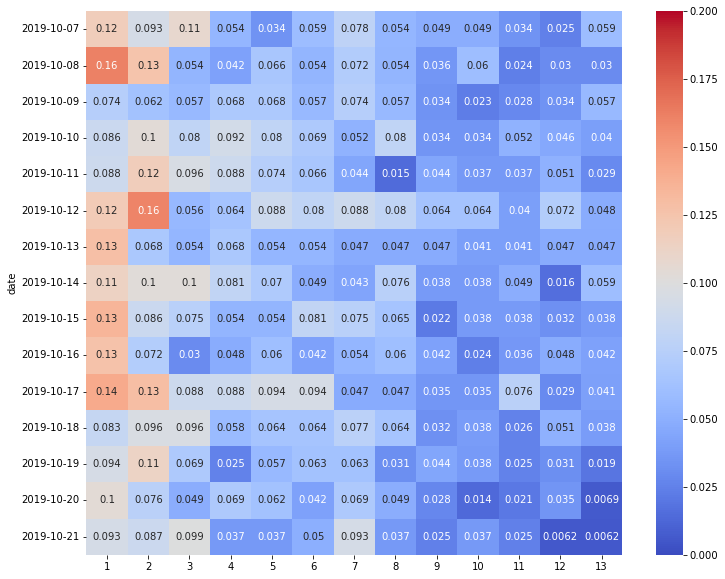

In [53]:
plt.figure(figsize=(12, 10))
sns.heatmap(retention.drop(columns=[0,'cohort_size']),annot = True,fmt='.2g',vmin=0, vmax=0.2, center= 0.1, cmap= 'coolwarm')
plt.show()

В целом можно сказать, что удержание не очень хорошее, максимальное удержание наблюдается для когорты, которая начала лайфтайм 8 октября (16% на второй день лайфтайма). Но наверное, это и правильно, пользователи зашли в приложение, нашли нужное объявление, позвонили и потом могут достаточно долго не возвращаться в приложение.

# Сегментация пользователей на основе их действий

## Сегментация пользователей через преобразование наблюдений с помощью pandas.get_dummies()

Я взяла датасет, к которому присоединен столбец с источником пользователей, но удалила из этого датасета столбцы с временем событий и датой. Решила посмотреть, а что будет, если посчитать, сколько каких событий совершал каждый из пользователей? Может быть у нас есть любители посмотреть фото? Или интересующиеся местами публикации объявлений? Или "серферы" по рекомендованным объявлениям?

Для этого я применила функцию pandas.get_dummies() к столбцам тип события и источник пользователя (про нее было упоминание в одном из уроков теории), затем сгруппировала полученный датасет по ид пользователя, и посчитала, сколько раз встречается конкретное событие по данному пользователю. Столбец ид пользователей стал индексом при группировке, его пришлось пока временно удалить,чтобы можно было провести сегментацию. Но это не страшно, по сути полученный датасет по индексу однозначно интерпретируется по пользователям в случае необходимости, и имеет такую же длину

In [54]:
segmentation = full_data.drop(columns=['event_time','date'])
segmentation = pd.get_dummies(segmentation, columns=['event_name','source'])
segmentation = segmentation.groupby('user_id').sum().reset_index()
segmentation_grouped = segmentation.drop(columns='user_id')
segmentation_grouped.head(3)

,event_name_advert_open,event_name_contacts_call,event_name_contacts_show,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex
0,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.00,0.00,35.00,0.00
1,2.00,5.00,11.00,2.00,0.00,33.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,71.00
2,0.00,0.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00


## Выбрать алгоритм сегментации пользователей, обосновать выбор алгоритма. Обучить модель на основании этого алгоритма и спрогнозировать кластеры пользователей

Воспользуемся наработками из последних проектов по кластеризации пользователей, в качестве алгоритма для сегментации выберем кластеризацию методом к средних, это достаточно простой алгоритм и хорошо себя зарекомендовавший.

In [55]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(segmentation_grouped)

Нарисуем дендрограмму по нашему датасету (внимание для отрисовки дендрограммы может потребоваться некоторое время):

Работу алгоритма сформируем через функцию, тк может пригодиться повторное вычисление кластеров, и метрики силуэта:

In [57]:
def kmeans_predict(k, data):
    """функция выполняет кластеризацию с помощью k-средних и вычисляет метрику силуэта при заданном числе кластеров k"""
    # задаём модель k_means с числом кластеров k и фиксируем значение random_state
    km = KMeans(n_clusters=k, random_state=0)
    # прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до k-1)
    labels = km.fit_predict(x_sc)
    # сохраняем метки кластера в поле нашего датасета
    data[f"cluster_{k}"] = labels
    # выводим статистику по средним значениям наших признаков по кластеру
    clusters = data.groupby([f"cluster_{k}"]).mean()
    display(clusters)
    print(f"Silhouette_score_{k}: {silhouette_score(x_sc, labels):.2f}")

In [58]:
for i in range(2,5):
    kmeans_predict(i, segmentation_grouped)

,event_name_advert_open,event_name_contacts_call,event_name_contacts_show,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex
cluster_2,,,,,,,,,,,,,,,,,,
0,0.88,0.13,0.78,0.26,0.68,2.35,0.84,0.06,0.08,0.11,0.18,0.08,0.03,0.14,7.04,3.78,3.64,6.21
1,16.61,0.00,8.48,2.12,7.01,1.75,0.32,0.63,1.35,1.57,2.03,0.84,0.52,1.52,71.36,31.38,28.63,56.10


Silhouette_score_2: 0.75


,event_name_advert_open,event_name_contacts_call,event_name_contacts_show,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,cluster_2
cluster_3,,,,,,,,,,,,,,,,,,,
0,0.77,0.13,0.77,0.26,0.67,2.34,0.85,0.04,0.07,0.09,0.15,0.06,0.03,0.14,6.72,3.81,3.15,6.13,0.00
1,25.08,0.00,48.25,7.42,30.17,14.75,2.58,0.25,3.42,0.33,1.83,0.33,0.00,4.17,221.58,214.33,0.00,145.83,1.00
2,11.75,0.00,3.60,1.16,3.48,1.57,0.10,0.66,0.84,1.44,1.86,0.92,0.45,0.83,43.37,10.52,28.55,32.94,0.59


Silhouette_score_3: 0.68


,event_name_advert_open,event_name_contacts_call,event_name_contacts_show,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,cluster_2,cluster_3
cluster_4,,,,,,,,,,,,,,,,,,,,
0,0.73,0.07,0.67,0.22,0.68,1.70,0.65,0.04,0.07,0.09,0.15,0.06,0.03,0.14,6.80,3.36,3.00,5.74,0.00,0.00
1,21.75,0.00,53.92,5.50,30.50,0.00,0.00,0.17,2.83,0.25,1.75,0.33,0.00,4.25,220.92,214.33,20.75,107.08,1.00,1.08
2,11.56,0.00,3.20,0.93,3.33,0.02,0.00,0.65,0.83,1.44,1.89,0.93,0.44,0.87,43.13,11.46,24.76,32.99,0.57,1.91
3,2.71,3.04,5.18,2.79,0.38,36.20,10.10,0.01,0.08,0.01,0.02,0.00,0.00,0.00,2.66,20.53,15.80,26.86,0.03,0.10


Silhouette_score_4: 0.67


Метрика силуэта при разбиении на 2 кластера составляет 0.75, это означает, что у нас сегментация получилась очень хорошо. Дополнительно глянем метрику силуэта на 3 и 4 кластера, там она чуть хуже (0.68 и 0.67 соответственно), но по дендрограмме также рекомендуется 4 кластера, поэтому выберем разбиение на 4 кластера.

In [59]:
segmentation_grouped['index'] = segmentation_grouped.index
segmentation['index'] = segmentation.index
segmentation_grouped = segmentation_grouped.merge(segmentation[['user_id','index']], on = 'index')

In [60]:
segmentation_grouped.groupby(['cluster_4'])['user_id'].count()

cluster_4
0    3951
1      12
2     239
3      91
Name: user_id, dtype: int64

## Cформируем типичные портреты пользователей: выделим несколько наиболее ярких групп и охарактеризуем их основные свойства. Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

Итак, по сегментации на 4 кластера:
    
    
0 кластер отличается низкой активностью во всех типах событий (и самым большим количеством пользователей),
    
    
1 кластер чаще всего открывают объявления и смотрят контакты,смотрят объявления на карте, это наша ЦА в проекте по сути, и ставят приложение они, переходя по ссылке с Гугла (но их меньше всего).
    
    
2 кластер приходит по ссылке с Яндекса, смотрит рекомендации, открывают объявления, но редко звонят, и в целом не проявляют так уж много активностей
    
    
3 кластер смотрят много фотографий, смотрят контакты и звонят через приложение продавцам, также активнее пользуются поисками, и приходят через ссылку из яндекса. Они осторожничают, и лично у меня возникает ощущение неуверенности в своих действиях у них


По размерам кластеры опять оказались очень неравномерны, 0 кластер самый большой, 2 кластер 239 человек, и 1 с 3 кластером маленькие

Итого, я бы сказала, что пользователи 0 кластера - по сути просто установили приложение, но потом ничего с ним не делали. Здесь и надо работать над персонализацией рекомендаций, добавлять персонализацию рекомендаций по геоположению, например.

## Какие кластеры склонны к целевому действию, а какие — нет?

Однозначно, 1 кластер склонны к целевому действию - просмотр контактов, а 0 кластер не склонен, 2 и 3 кластеры находятся между ними, и дают небольшое количество целевых действий.

## Сравним метрики для пользователей всех кластеров

Присоединим столбец с кластером пользователя к общим данным и рассчитаем отдельно метрики для каждого кластера:

In [61]:
full_data = full_data.merge(segmentation_grouped[['cluster_4','user_id']], on = 'user_id' )
mobile_sourсes = mobile_sourсes.merge(segmentation_grouped[['user_id','cluster_4']], on= 'user_id')

In [62]:
def clastered_conv(k):
    conv =( full_data[full_data['cluster_4']==k]
                       .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
                       .rename(columns={'user_id': 'count'})
                       .sort_values(by='count',ascending=False)
                       .reset_index()
                      )
    conv['part_from_all, %'] = round(conv['count'] / len(mobile_sourсes[mobile_sourсes['cluster_4']==k]) *100 , 2)

    print(f'{i} cluster')
    display(conv[conv['event_name']=='contacts_show']['part_from_all, %'])

In [63]:
for i in range(4):
    clastered_conv(i)

0 cluster


3   20.78
Name: part_from_all, %, dtype: float64

1 cluster


1   91.67
Name: part_from_all, %, dtype: float64

2 cluster


6   33.89
Name: part_from_all, %, dtype: float64

3 cluster


1   74.73
Name: part_from_all, %, dtype: float64

**Конверсия в целевое действие** составляет 

0 cluster - 
(4 место в списке действий пользователей)  20.78%

1 cluster - 
(2 место)   91.67%

2 cluster - 
(7 место)   33.89%
    
3 cluster - 
(2 место)   74.73%

**Суммарное время, проведенное в приложении пользователями разных кластеров**

In [64]:
event_dataset = event_dataset.merge(segmentation_grouped[['cluster_4','user_id']], on = 'user_id' )

In [65]:
def clastered_time(k):
    """Функция строит гистограммы распределения времени по для 4 кластеров"""
    time_ap = (event_dataset[event_dataset['cluster_4']==k].groupby('user_id').agg({'time_on_page': 'sum'})
               .rename(columns={'time_on_page': 'sec'}).sort_values(by='sec',ascending=False).reset_index())
    time_ap['min'] = round( time_ap['sec'] / 60 , 2)
    time_ap = time_ap[time_ap['min']<=150]

    plt.figure(figsize=(10,5))

    plt.hist(time_ap['min'], bins=50)
    plt.title(f"{k} кластер")
    plt.xlabel('Количество минут в приложении')
    plt.ylabel('Количество пользователей')

    plt.show()
    print(f"Медианное время в приложении у {k} кластера {round(time_ap['min'].median(),2) } минут" )

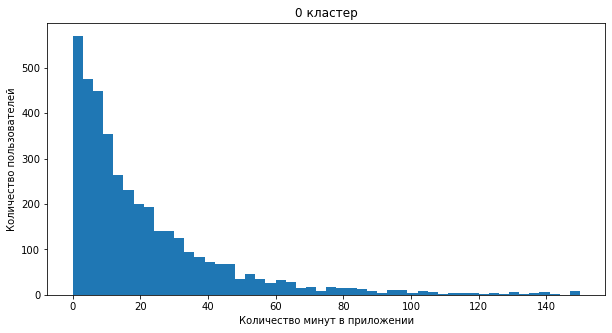

Медианное время в приложении у 0 кластера 13.21 минут


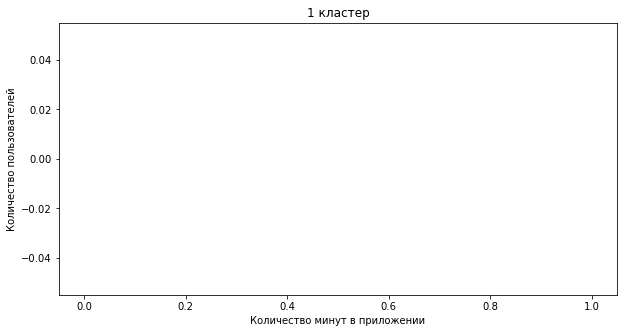

Медианное время в приложении у 1 кластера nan минут


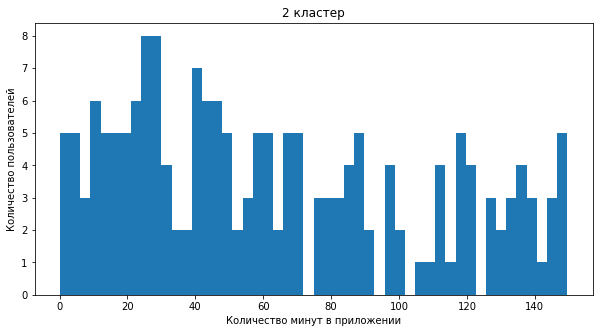

Медианное время в приложении у 2 кластера 54.2 минут


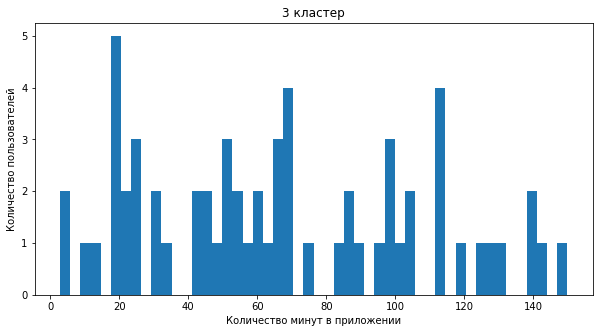

Медианное время в приложении у 3 кластера 64.19 минут


In [66]:
for i in range(4):
    clastered_time(i)

Время в приложении у пользователей разных кластеров отличается значительно, причем у 1 кластера суммарных наблюдений среднего времени, меньшего 150 минут,не оказалось, все сессии вместе составляют до фильтрации значительно больше времени( 


**Частота совершения действий в приложении пользователями разных кластеров**

In [67]:
def clastered_frequency(k):
    freq = (event_dataset[event_dataset['cluster_4']==k].pivot_table(index = 'date', 
                                                                      columns='user_id', 
                                                                      values = 'event_time', 
                                                                      aggfunc = 'count').reset_index().fillna(0))
    freq = freq.describe().reset_index(drop=True)
    
    plt.figure(figsize=(10,5))

    plt.hist(freq.iloc[1], bins=50)
    plt.title(f"Среднее число действий пользователей в сутки в {k} кластере")
    plt.xlabel('Среднее число действий в сутки')
    plt.ylabel('Количество пользователей')

    plt.show()
    print(f"Медианное частота действий пользователей у {k} кластера", round(freq.iloc[1].median(),2) )

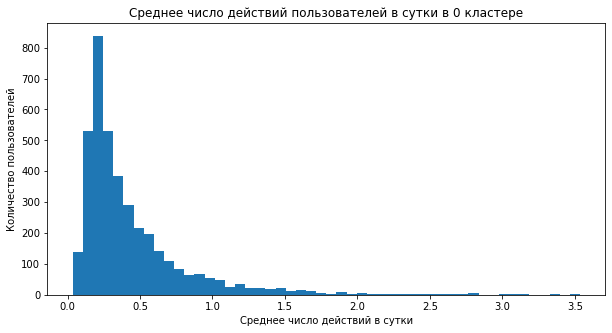

Медианное частота действий пользователей у 0 кластера 0.29


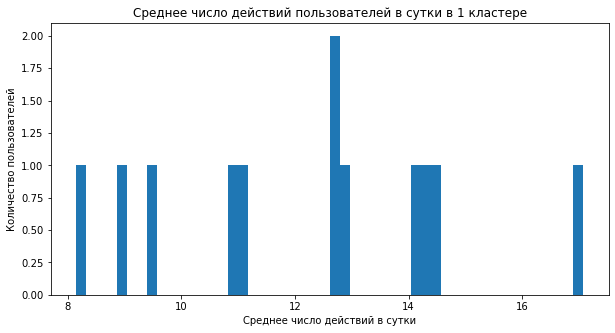

Медианное частота действий пользователей у 1 кластера 12.66


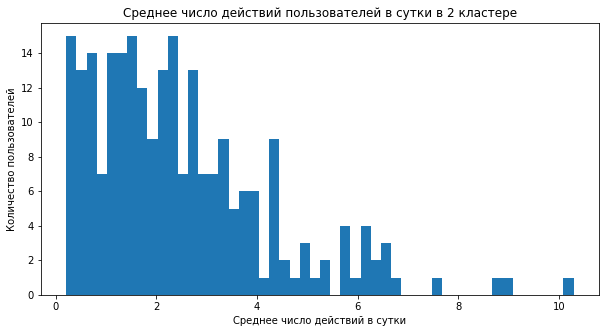

Медианное частота действий пользователей у 2 кластера 2.14


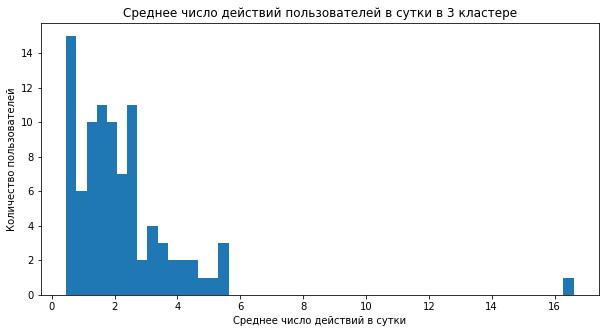

Медианное частота действий пользователей у 3 кластера 1.93


In [68]:
for i in range(4):
    clastered_frequency(i)

**Retention rate для пользователей разных кластеров**

In [69]:
retention_user = retention_user.merge(mobile_sourсes[['user_id','cluster_4']], on = 'user_id')

In [70]:
def clastered_retention(k):
    """Функция строит тепловую карту retention rate для кластеров"""
    #профили пользователей
    retention_users = retention_user[retention_user['cluster_4']==k]

    sessions= (event_dataset[event_dataset['cluster_4']==k].groupby(['session_id'])[['user_id', 'event_time']]
               .agg({'user_id':'first','event_time':'first'})
               .rename(columns={'event_time':'session_start'})
               .reset_index()
              )

    # задаём момент и горизонт анализа данных
    observation_date = datetime(2019, 11, 3).date()
    horizon_days = 14

    retention_raw, retention = get_retention(retention_users , sessions, observation_date, horizon_days)

    plt.figure(figsize=(10,5))
    sns.heatmap(retention.drop(columns=[0,'cohort_size']),annot = True,fmt='.2g',
                vmin=0, vmax=0.5, center= 0.25, cmap= 'coolwarm')
    plt.title(f"Retention rate для {k} кластера")
    plt.xlabel('Lifetime')
    plt.ylabel('Когорты')
    
    plt.show()


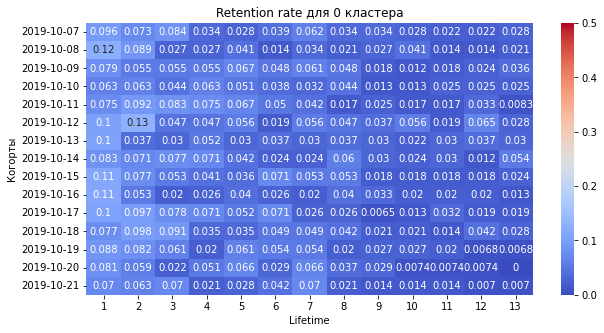

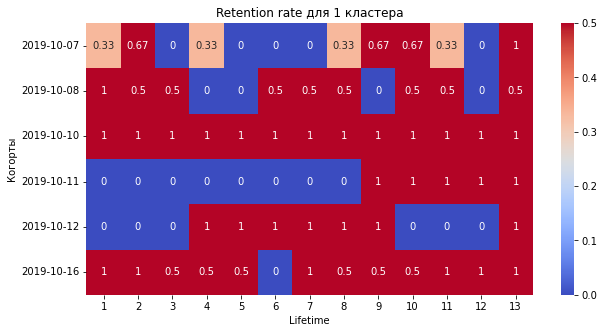

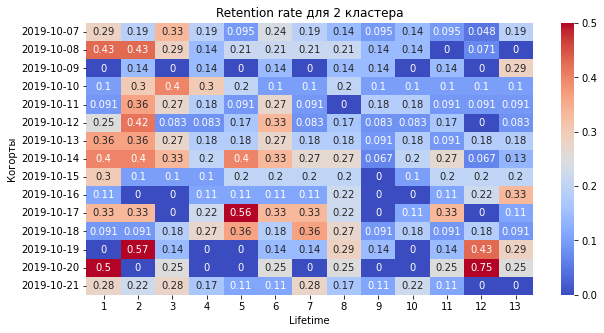

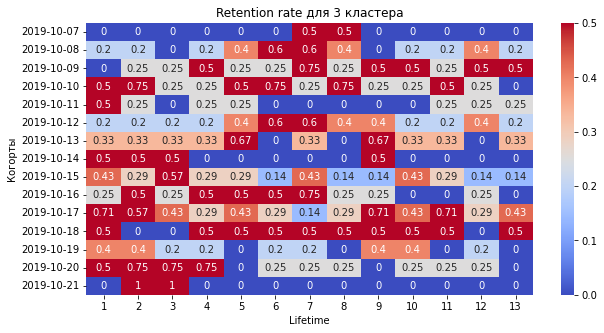

In [71]:
for i in range(4):
    clastered_retention(i)

Чтож, и здесь отличился 1 кластер! Во первых, у него получилось меньше когорт, тк видимо, в некоторые дни не было регистрации новых пользователей. А судя по тому, что в некоторые дни retention rate равен 1, то в в дни до этого видимо сколько было пользователей, столько и вернулось, а может там вообще были зарегистрированы по 1 пользователю, который и вернулся смотреть объявления?

Здесь, на 4 кластерах, мне больше всего нравится хитмап у 2 кластера, а меньше всего у 3 кластера. Хитмап 1 кластера вообще без комментариев, а хитмап 0 кластера = это такое очень стабильное "болото тихушников" )

# Проверка статистических гипотез

## Сформулируем основную и альтернативную гипотезу для каждого из следующих 2 подпунктов. Выберем критерий для проверки каждой из гипотез, обоснуем, почему используем такой p-value

Для указанных ниже гипотез я выбрала Z-тест в качестве критерия, тк требуется в обеих гипотезах сравнить доли "успехов". p-value взяла 5%, этого достаточно для наших групп

## Конверсия групп пользователей в просмотры контактов с разными источниками пользователей различна

Данная формулировка выше подразумевает, что необходимо сравнить выборки по источникам данных google и yandex.

Для проверки статистических отличий напишем функцию, которая применяет критерий Z-тест (который проверяет равенство долей в двух выборках). Z-тест применим, если доля успеха в каждой выборке * объем выборки >= 5, это условие выполняется (по сути это количество появлений каждого события у нас)
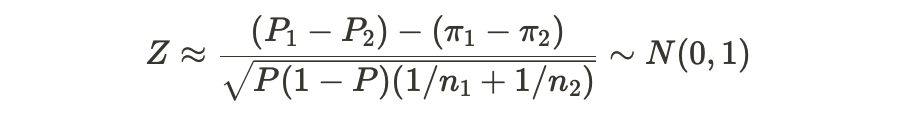

In [72]:
def check_z(successes1, successes2, trials1, trials2, alpha=0.05):
    """
    Функция применяется дляя проверки гипотезы о равенстве долей
    :param successes1:  (int)
                        частота события в 1 группе  
    :param successes2:  (int)
                        частота события во 2 группе
    :param trials1:     (int)
                        количество наблюдений в 1 группе
    :param trials2:     (int)
                        количество наблюдений во 2 группе
    :param alpha:       (float)
                        уровень значимости, по умолчанию 0.05
    :return: 
    """
   # считаем доли успехов
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = ( p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('доля в 1 выборке: ', '{:.3f}'.format(p1))
    print('доля в 2 выборке: ', '{:.3f}'.format(p2))
    if (p_value < alpha):
        print('p_value составляет:','{:.3f}'.format(p_value),
              '. Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('p_value составляет:', '{:.3f}'.format(p_value),
              '. Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными')

Сформулируем гипотезы:

$H_{0}$  - конверсия групп пользователей, установивших приложение по ссылке из google, совпадает с конверсией пользователей, установивших приложение по сссылке из yandex; 

$H_{1}$  - конверсия групп пользователей, установивших приложение по ссылке из google, отличается от конверсии пользователей, установивших приложение по сссылке из yandex. 

In [73]:
user_unique_google =( full_data[full_data['source']=='google']
              .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
              .rename(columns={'user_id': 'count'})
              .sort_values(by='count',ascending=False)
              .reset_index()
             )

user_unique_google

,event_name,count
0,tips_show,651
1,photos_show,363
2,map,354
3,search_1,305
4,contacts_show,275
5,advert_open,195
6,search_5,137
7,favorites_add,114
8,search_4,108
9,tips_click,71


In [74]:
user_unique_yandex =( full_data[full_data['source']=='yandex']
              .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
              .rename(columns={'user_id': 'count'})
              .sort_values(by='count',ascending=False)
              .reset_index()
             )

user_unique_yandex

,event_name,count
0,tips_show,1310
1,map,687
2,contacts_show,478
3,photos_show,443
4,search_1,345
5,advert_open,297
6,search_5,210
7,search_4,163
8,favorites_add,160
9,tips_click,150


In [75]:
check_z(user_unique_google.loc[4, 'count'],
        user_unique_yandex.loc[2, 'count'], 
        len(mobile_sourсes[mobile_sourсes['source']=='google']),
        len(mobile_sourсes[mobile_sourсes['source']=='yandex']))

доля в 1 выборке:  0.244
доля в 2 выборке:  0.247
p_value составляет: 0.824 . Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными


Следовательно, нет причин считать значимой разницу в конверсии пользователей, имеющих разные источники

## Частота клика по рекомендованному объявлению у пользователей различных кластеров (сформированных в разделе 4)  - отличается

Сформулируем гипотезы:

$H_{0}$  - частота клика по рекомендованному объявлению у пользователей из 0 кластера совпадает с частотой клика у пользователей 1 кластера; 

$H_{1}$  - частота клика по рекомендованному объявлению у пользователей из 0 кластера отличается от частоты клика у пользователей 1 кластера. 

Используем уже имеющиеся отфильтрованные датасеты:

In [76]:
segmentation_grouped.groupby(['cluster_2'])['user_id'].count().reset_index()

,cluster_2,user_id
0,0,4140
1,1,153


In [77]:
successes1 = segmentation_grouped[segmentation_grouped['cluster_2']==0]['event_name_tips_click'].nunique()
successes2 = segmentation_grouped[segmentation_grouped['cluster_2']==1]['event_name_tips_click'].nunique()
trials1 = segmentation_grouped[segmentation_grouped['cluster_2']==0]['event_name_tips_click'].count()
trials2 = segmentation_grouped[segmentation_grouped['cluster_2']==1]['event_name_tips_click'].count()

In [78]:
check_z(successes1, successes2, trials1, trials2)

доля в 1 выборке:  0.003
доля в 2 выборке:  0.092
p_value составляет: 0.000 . Отвергаем нулевую гипотезу: между долями есть значимая разница


Следовательно, частота кликов по рекомендациям у пользователей из разных кластеров в среднем отличается значимо

# Выводы и рекомендации

## Сформулируем основные выводы

Оценены сценарии поведения пользователей, построены воронки, конверсия пользователей:

Конверсия в целом по датасету для contacts_show составляет  22.85%,
а по кластерам:

0 cluster  20.8%

1 cluster - 91.7%

2 cluster - 33.9%

3 cluster - 74.7%


среднее число событий на одного пользователя – 17

среднее время просмотра одной страницы 2 минуты

среднее время, проведенное в приложении за 4 недели – 31 минута

для пользователей, привлеченных ранее 20 октября, рассчитан Retention Rate, который ожидаемо невысок из-за специфики приложения

С помощью метода К средних выполнили сегментацию пользователей на 4 кластера, метрика силуэта 0.67, контрольные метрики пользователей отличаются для разных кластеров.

Проверена 2 гипотезы:

1) конверсия пользователей, установивших приложение по ссылке из Yandex и Google, оказалась одинаковой

2) частота клика по рекомендованным объявлениям отличается у пользователей из разных кластеров 

## Сформулируем рекомендации

Следует обратить внимание на пользователей, попавших в 1 кластер, потому что они имеют большую конверсию, и более высокий Retention Rate.

Создается впечатление, что пользователи из 3 кластера сидят в приложении и просто листают фото, необходимо детализировать рекомендации, возможно использовать гео положение пользователя, предлагать чаще рекомендации между строками поиска например

Нужно обратить внимание на резкое падение числа пользователей после просмотра фото или после рекомендованных объявлений, это означает, что именно эти события срабаывают не совсем так, как хотелось бы. Необходимо разработать алгоритмы, которые бы обеспечивали переход пользователей из 0 кластера в 1.
